# 8. Alpha diversity

In [2]:
# Load diversity libraries
library(tidyverse)
library(data.table)
library(reshape2)
library(ggplot2)
library(RColorBrewer)
library(vegan) 
library(phyloseq) 
library(dplyr) 
library(ggpubr) 
library(Hmisc) 
library(corrplot)
library(scales)
library(broom)
library(ecodist) 
library(rstatix)
library(multcompView)
library(patchwork)
library(forcats)

In [3]:
## Create color palette
purples <- brewer.pal(n = 5, name = "BuPu")[-c(1:4)] # taking a few colors from the RColorBrewer Package
blues <- rev(brewer.pal(n = 5, name = "Blues")[-1])
greens <- brewer.pal(n = 5, name = "YlGn")[-1]
oranges <- c("#FFEC8B", "#FECC5C", "#fe9a4d", "#fe6f01") # appending some nice oranges, reds, purples, beiges and aquamarines
reds <- c("#b30024", "#ff0033", "#ff554d", "#ff9e99")
purples <- append(purples, c("#ac39ac", "#cc66cc", "#ffb3ff"))
beiges <- c("#999966", "#adad85", "#ccccb3")
aquamarines <- c("#25a696", "#43d6c5", "#96e8df")
pinks <- c("#9F2B68", "#F33A6A")
gray <- c("#808080")
custom_colors <- c(blues, reds, oranges, greens, purples, rev(beiges), aquamarines, pinks) # combinig all colors in a single vector

In [4]:
setwd("/home/strawberry/Documents/Collaborations/sinusite_edwin/data")

In [5]:
rarefied_data <- read.delim("./rarefied_data.tsv")
metadata_filtered <- read.delim("./metadata_filtered_Diversity.tsv")

OTU = otu_table(rarefied_data, taxa_are_rows = FALSE) 
sampledata = sample_data(metadata_filtered) 
rownames(sampledata) <- sampledata$ID_Sample 
sampledata <- sampledata[,-1] # Remove ID_Sample column to avoid redundancy

print(head(OTU))
print(head(sampledata))

OTU Table:          [331 taxa and 6 samples]
                     taxa are columns
            X.Enterobacter. X.Eubacterium..sulci.group
0001967K_T1               0                          0
0001967K_T3               0                          0
0001967K_T6               0                          0
0088303G_T0               0                          0
0088303G_T1               0                          0
0088303G_T3               0                          0
            X.Eubacterium..yurii.group X.Ruminococcus..gnavus.group Abiotrophia
0001967K_T1                          0                            0           0
0001967K_T3                          0                            0           0
0001967K_T6                          0                            0           0
0088303G_T0                          0                            0           0
0088303G_T1                          0                            0           0
0088303G_T3                          0              

In [6]:
## Compute alpha diversity indices
physeq1 = phyloseq(OTU,sampledata) # Create phyloseq object
richness <- estimate_richness(physeq1) # Compute alpha diversity indices
richness$ID_Sample <- rownames(richness)  # Retain sample names

write.table(richness, "AlhaDiversity_Indexes.tsv", quote = F, sep = "\t", row.names = F)

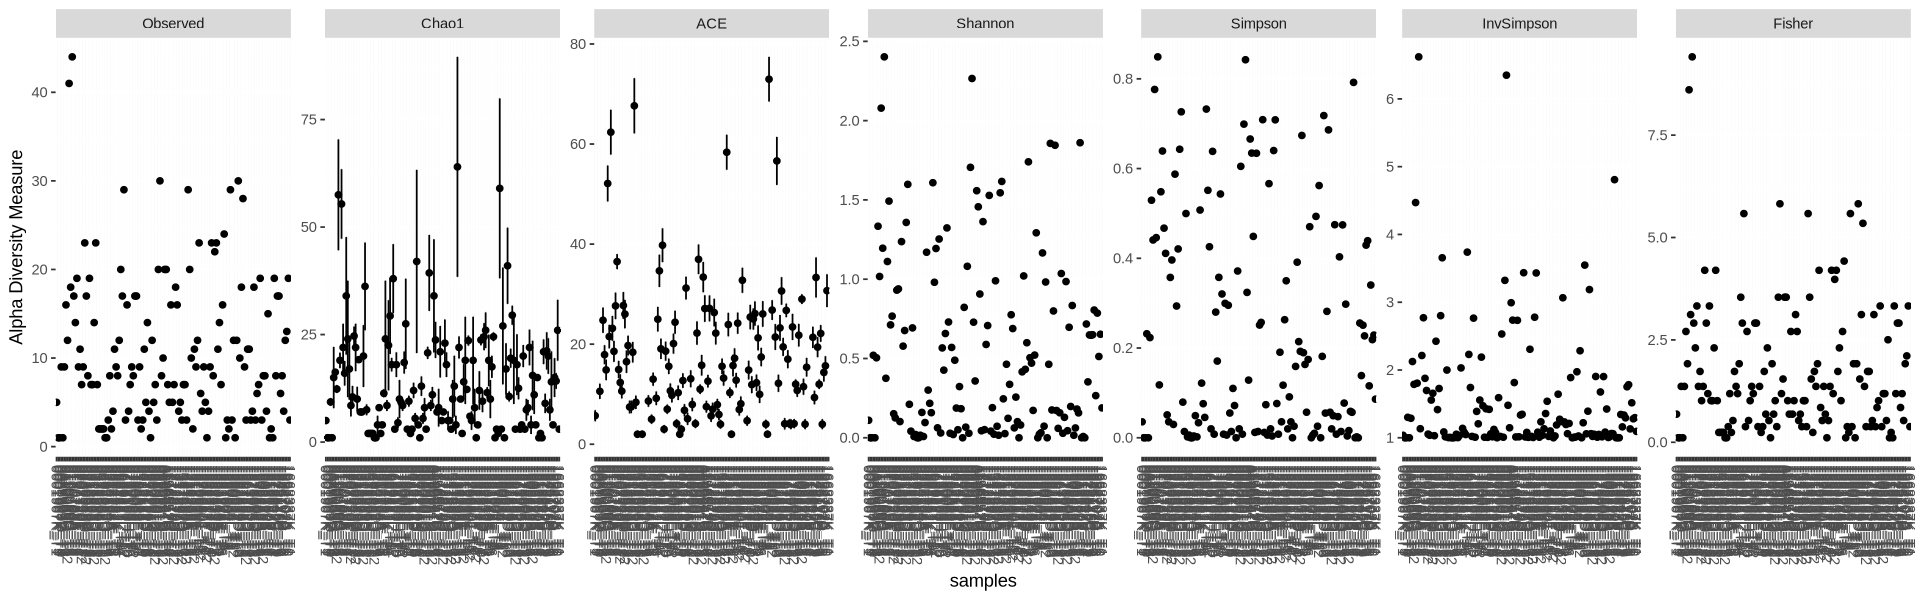

In [7]:
## Plot alpha diversity without grouping 
options(repr.plot.width=16, repr.plot.height=5) 
plot_richness(physeq1, )

In [8]:
# Ensure Timepoint is extracted from ID_Sample
richness2 <- richness %>%
  mutate(Timepoint = gsub(".*_(T[0-9]+)$", "\\1", ID_Sample),
         Subject = gsub("_(T[0-9]+)$", "", ID_Sample))  # Extract Subject ID
print(head(richness2))

             Observed     Chao1  se.chao1      ACE   se.ACE   Shannon  Simpson
X0001967K_T1        5  5.000000 0.2236068  5.70059 1.103161 0.1102647 0.035554
X0001967K_T3        1  1.000000 0.0000000      NaN      NaN 0.0000000 0.000000
X0001967K_T6        1  1.000000 0.0000000      NaN      NaN 0.0000000 0.000000
X0088303G_T0        9  9.333333 0.9148009 10.57551 1.525651 0.5201432 0.231824
X0088303G_T1        1  1.000000 0.0000000      NaN      NaN 0.0000000 0.000000
X0088303G_T3        9 15.000000 7.1227336 24.78462 2.529930 0.5043862 0.223252
             InvSimpson    Fisher    ID_Sample Timepoint   Subject
X0001967K_T1   1.036865 0.6863709 X0001967K_T1        T1 X0001967K
X0001967K_T3   1.000000 0.1096721 X0001967K_T3        T3 X0001967K
X0001967K_T6   1.000000 0.1096721 X0001967K_T6        T6 X0001967K
X0088303G_T0   1.301785 1.3638955 X0088303G_T0        T0 X0088303G
X0088303G_T1   1.000000 0.1096721 X0088303G_T1        T1 X0088303G
X0088303G_T3   1.287419 1.3638955 X0088303G_T

In [9]:
# Define the correct timepoint order
timepoint_order <- c("T0", "T1", "T3", "T6", "T12")

# Convert Timepoint to an ordered factor
richness2$Timepoint <- factor(richness2$Timepoint, levels = timepoint_order, ordered = TRUE)

In [10]:
# Function to perform Wilcoxon test and create boxplots for different alpha diversity metrics
plot_alpha_diversity <- function(metric) {
    # Perform Wilcoxon paired test for the chosen metric
    wilcox_test_result <- richness2 %>%
        select(Subject, Timepoint, !!sym(metric)) %>%  # Keep relevant columns
        pivot_wider(names_from = Timepoint, values_from = !!sym(metric)) %>%  # Reshape for paired analysis
        pivot_longer(cols = -Subject, names_to = "Timepoint", values_to = "Metric") %>%
        mutate(Metric = as.numeric(Metric)) %>%
        pairwise_wilcox_test(Metric ~ Timepoint, paired = TRUE, p.adjust.method = "bonferroni")
    
    print(wilcox_test_result)  # Print test results
    
    # Plot the chosen alpha diversity metric
    plot <- ggplot(richness2, aes(x = Timepoint, y = !!sym(metric))) +
        geom_boxplot(aes(fill = Timepoint), alpha = 0.3) +  # Boxplots with light fill
        geom_jitter(width = 0.2, alpha = 0.4, color = "black") +  # Jitter for individual points
        theme_minimal() +
        labs(title = paste(metric),
             x = "Timepoint",
             y = paste(metric, "Index")) +
        scale_fill_brewer(palette = "Set2") +  # Nice color scheme
        theme(legend.position = "none")  # Remove legend since Timepoint is on x-axis
    
    return(plot)  # Return the plot object
}

# A tibble: 10 × 9
   .y.    group1 group2    n1    n2 statistic        p p.adj p.adj.signif
 * <chr>  <chr>  <chr>  <int> <int>     <dbl>    <dbl> <dbl> <chr>       
 1 Metric T0     T1        37    31       324 0.000668 0.007 **          
 2 Metric T0     T12       37    20       130 0.054    0.539 ns          
 3 Metric T0     T3        37    34       322 0.067    0.667 ns          
 4 Metric T0     T6        37    28       186 0.317    1     ns          
 5 Metric T1     T12       31    20        46 0.454    1     ns          
 6 Metric T1     T3        31    34       100 0.16     1     ns          
 7 Metric T1     T6        31    28        69 0.189    1     ns          
 8 Metric T12    T3        20    34        54 0.177    1     ns          
 9 Metric T12    T6        20    28        38 0.13     1     ns          
10 Metric T3     T6        34    28        73 0.029    0.288 ns          
# A tibble: 10 × 9
   .y.    group1 group2    n1    n2 statistic     p p.adj p.adj.signif
 * 

Warning message:
“Removed 23 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 23 rows containing missing values or values outside the scale range (`geom_point()`).”


png 
  3

pdf 
  2

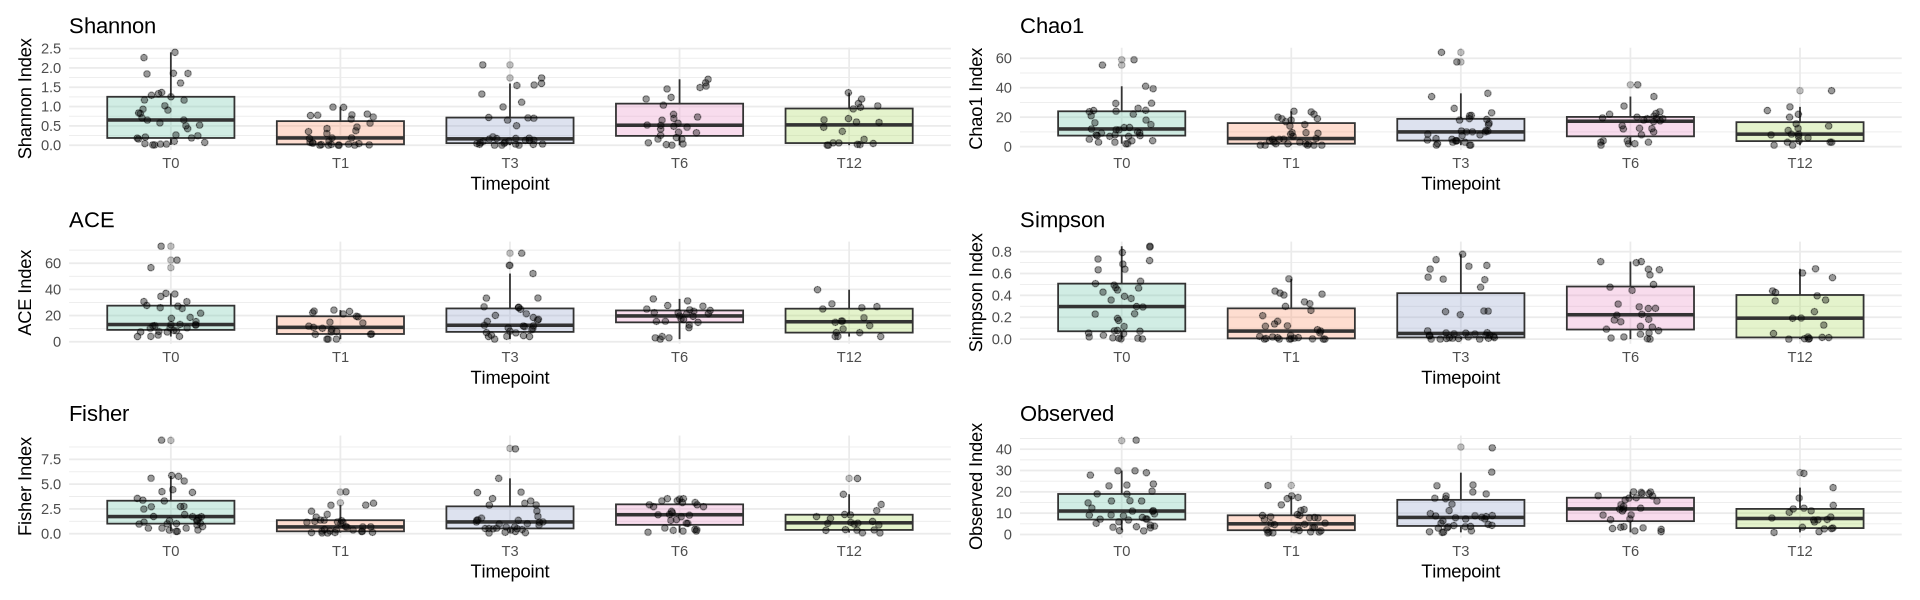

In [11]:
# Apply the function for each metric (Shannon, Chao1, ACE, Simpson, Fisher, Observed)
metrics <- c("Shannon", "Chao1", "ACE", "Simpson", "Fisher", "Observed")

# Create a list of plots
plots <- lapply(metrics, plot_alpha_diversity)

# Combine the plots into a single grid
combined_plot <- wrap_plots(plots, ncol = 2)  # Adjust ncol as needed (e.g., 2 columns)

# Print the combined plot
combined_plot

# Save the plot as a PNG file
dev.copy(png, filename = "combined_AlphaDiv_plot.png", width = 1800, height = 1200, res = 300)
dev.off()  # Close the PNG device

# A tibble: 10 × 9
   .y.    group1 group2    n1    n2 statistic        p p.adj p.adj.signif
 * <chr>  <chr>  <chr>  <int> <int>     <dbl>    <dbl> <dbl> <chr>       
 1 Metric T0     T1        37    31       324 0.000668 0.007 **          
 2 Metric T0     T12       37    20       130 0.054    0.539 ns          
 3 Metric T0     T3        37    34       322 0.067    0.667 ns          
 4 Metric T0     T6        37    28       186 0.317    1     ns          
 5 Metric T1     T12       31    20        46 0.454    1     ns          
 6 Metric T1     T3        31    34       100 0.16     1     ns          
 7 Metric T1     T6        31    28        69 0.189    1     ns          
 8 Metric T12    T3        20    34        54 0.177    1     ns          
 9 Metric T12    T6        20    28        38 0.13     1     ns          
10 Metric T3     T6        34    28        73 0.029    0.288 ns          


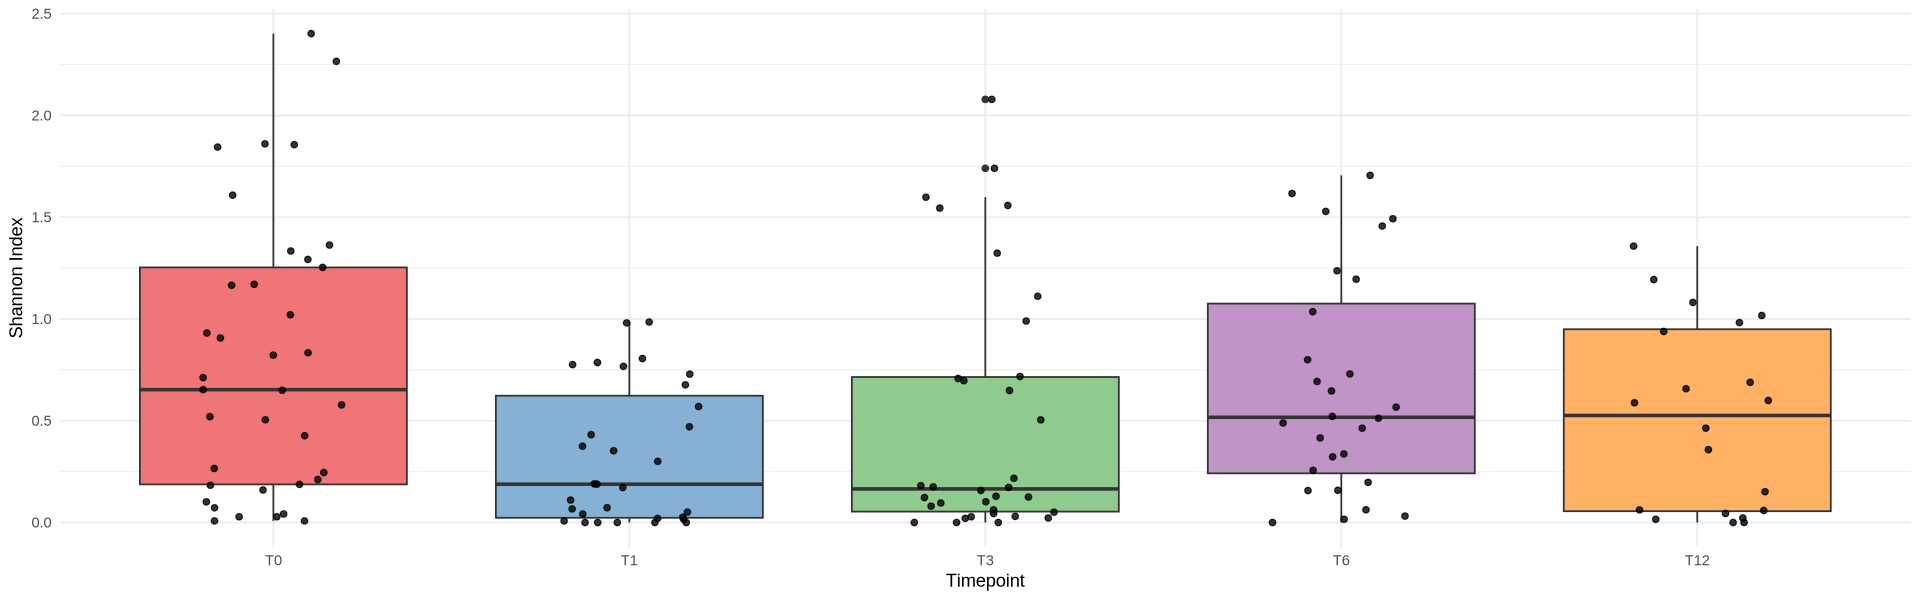

In [16]:
# Function to perform Wilcoxon test and create a boxplot for the Shannon index
#### specify color for timepoints to standardize across figures
timepoint_colors <- c(
  "T0" = "#ef7576",
  "T1" = "#87b1d4",
  "T3" = "#90cb8e",
  "T6" = "#c194c8",
  "T12" = "#ffb266"
)
plot_alpha_diversity_shannon <- function() {
    metric <- "Shannon"  # Define the metric directly
    
    # Perform Wilcoxon paired test for the Shannon index
    wilcox_test_result <- richness2 %>%
        select(Subject, Timepoint, !!sym(metric)) %>%  # Keep relevant columns
        pivot_wider(names_from = Timepoint, values_from = !!sym(metric)) %>%  # Reshape for paired analysis
        pivot_longer(cols = -Subject, names_to = "Timepoint", values_to = "Metric") %>%
        mutate(Metric = as.numeric(Metric)) %>%
        pairwise_wilcox_test(Metric ~ Timepoint, paired = TRUE, p.adjust.method = "bonferroni")
    
    print(wilcox_test_result)  # Print test results
    
    # Plot the Shannon index
    plot <- ggplot(richness2, aes(x = Timepoint, y = Shannon)) +
        geom_boxplot(aes(fill = Timepoint), alpha = 1.0) +  # Boxplot with light fill
        scale_fill_manual(values = timepoint_colors) +  # apply custom colors
        geom_jitter(width = 0.2, alpha = 0.8, color = "black") +  # Jitter for individual points
        theme_minimal() +
        labs(x = "Timepoint",
             y = "Shannon Index") +
        # scale_fill_brewer(palette = "Set2") +  # Nice color scheme
        theme(legend.position = "none")  # Remove legend since Timepoint is on x-axis
    
    return(plot)  # Return the plot object
}

# Generate the Shannon plot
shannon_plot <- plot_alpha_diversity_shannon()

# Print the plot
print(shannon_plot)

# Save the plot as a PNG file
ggsave("Shannon_AlphaDiv_plot.png", plot = shannon_plot, width = 6, height = 4, dpi = 300)

In [14]:
# Assess changes in shannon index across timepoints for each patient
## Set the desired order of timepoints
richness2$Timepoint <- factor(richness2$Timepoint, levels = c("T0", "T1", "T3", "T6", "T12"))

## Perform pairwise Wilcoxon test for **consecutive** timepoints
consec_pairs <- richness2 %>%
  select(Subject, Timepoint, Shannon) %>%
  pivot_wider(names_from = Timepoint, values_from = Shannon) %>%
  pivot_longer(-Subject, names_to = "Timepoint", values_to = "Shannon") %>%
  mutate(Timepoint = factor(Timepoint, levels = c("T0", "T1", "T3", "T6", "T12"))) %>%
  drop_na()

# Now filter for consecutive pairs
pairwise_tests <- consec_pairs %>%
  group_by(Subject) %>%
  arrange(Subject, Timepoint) %>%
  mutate(NextTimepoint = lead(Timepoint),
         NextShannon = lead(Shannon)) %>%
  ungroup() %>%
  filter(!is.na(NextShannon)) %>%
  group_by(Comparison = paste0(Timepoint, "_vs_", NextTimepoint)) %>%
  summarise(p.value = wilcox.test(Shannon, NextShannon, paired = TRUE)$p.value) %>%
  mutate(p.adj = p.adjust(p.value, method = "bonferroni"))

print(pairwise_tests)

Warning message:
“There was 1 warning in `summarise()`.
ℹ In argument: `p.value = wilcox.test(Shannon, NextShannon, paired = TRUE)$p.value`.
ℹ In group 6: `Comparison = "T3_vs_T6"`.
Caused by warning in `wilcox.test.default()`:
! cannot compute exact p-value with zeroes”


# A tibble: 7 × 3
  Comparison  p.value   p.adj
  <chr>         <dbl>   <dbl>
1 T0_vs_T1   0.000668 0.00467
2 T0_vs_T3   0.625    1      
3 T1_vs_T3   0.160    1      
4 T1_vs_T6   0.750    1      
5 T3_vs_T12  0.25     1      
6 T3_vs_T6   0.0288   0.202  
7 T6_vs_T12  0.130    0.908  


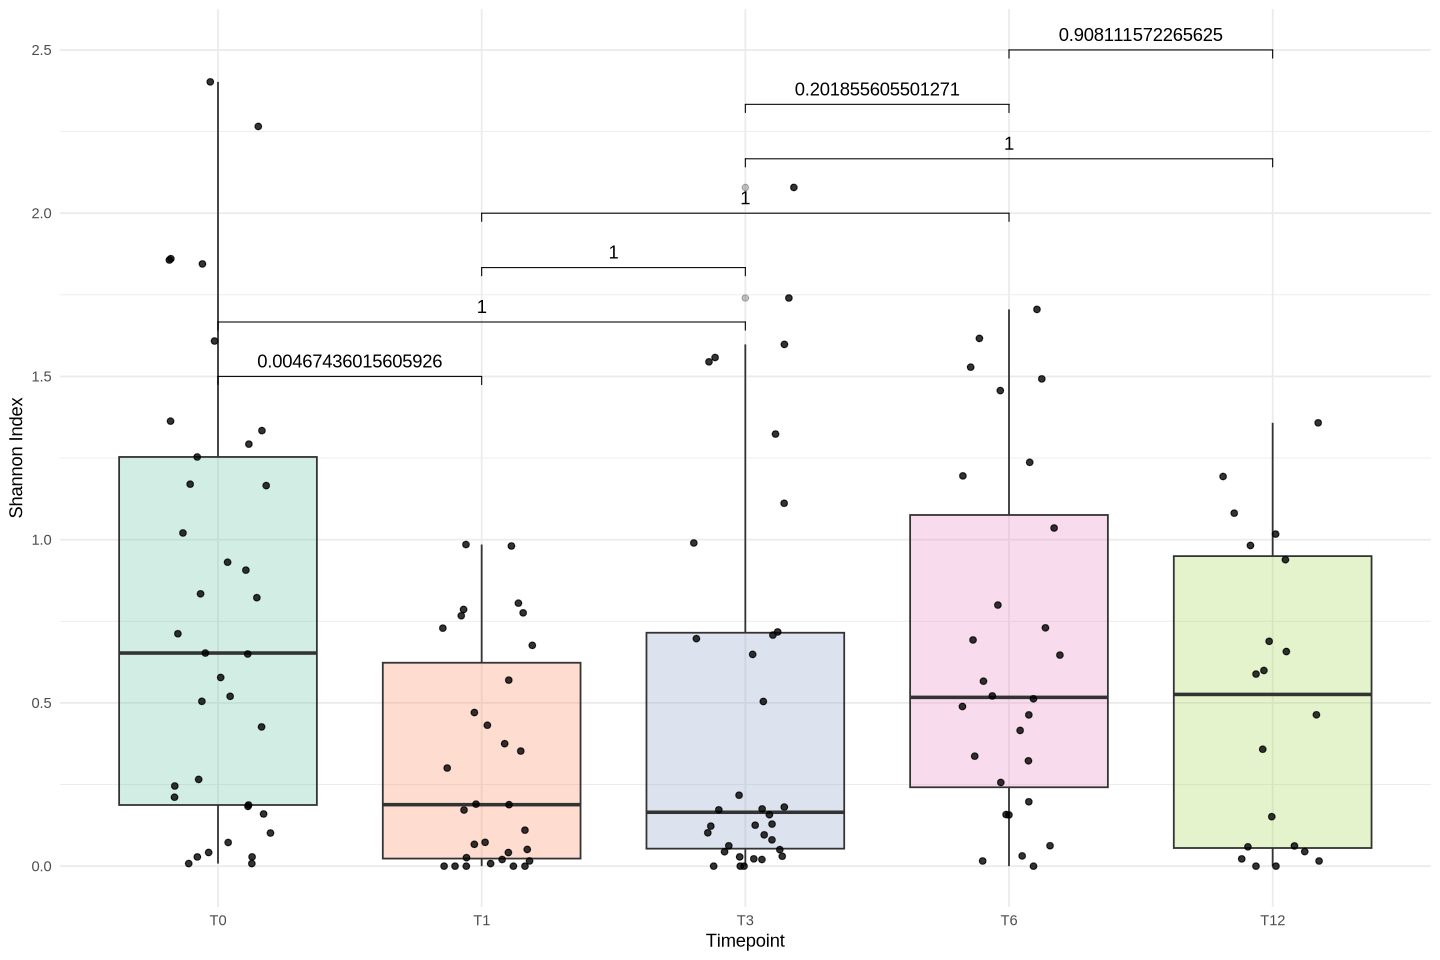

In [15]:
# Prepare p-value annotations
options(repr.plot.width = 12, repr.plot.height = 8)

pval_df <- pairwise_tests %>%
  separate(Comparison, into = c("group1", "group2"), sep = "_vs_") %>%
  mutate(y.position = seq(1.5, 2.5, length.out = n()))  # Adjust y positions manually

shannon_plot +
  stat_pvalue_manual(pval_df, label = "p.adj", tip.length = 0.01)
